In [1]:
# import some pkg
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json
import folium
from branca.colormap import linear
import requests
import time
import tqdm
from shapely.wkb import loads as load_wkb
import matplotlib.pyplot as plt

In [2]:
# some SRID
GAD2020_SRID = 7844
GDA94_SRID = 4283
WGS84_SRID = 4326

In [3]:
# utils

def data_summary(df): 
    print(df.info())
    print(df.head())

def shapely_to_WKT(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

def check_unique(df, key): # check wether a key is unique among dataset
    return df[key].nunique() == len(df[key])


# Task 1 Import all datasets, clean if needed

In [4]:
#SA2 raw data
sa2_data = gpd.read_file("SA2_2021_AUST_GDA2020.shp")
data_summary(sa2_data)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SA2_CODE21  2473 non-null   object  
 1   SA2_NAME21  2473 non-null   object  
 2   CHG_FLAG21  2473 non-null   object  
 3   CHG_LBL21   2473 non-null   object  
 4   SA3_CODE21  2473 non-null   object  
 5   SA3_NAME21  2473 non-null   object  
 6   SA4_CODE21  2473 non-null   object  
 7   SA4_NAME21  2473 non-null   object  
 8   GCC_CODE21  2473 non-null   object  
 9   GCC_NAME21  2473 non-null   object  
 10  STE_CODE21  2473 non-null   object  
 11  STE_NAME21  2473 non-null   object  
 12  AUS_CODE21  2473 non-null   object  
 13  AUS_NAME21  2473 non-null   object  
 14  AREASQKM21  2454 non-null   float64 
 15  LOCI_URI21  2473 non-null   object  
 16  geometry    2454 non-null   geometry
dtypes: float64(1), geometry(1), object(15)
memory usage: 328.6+ KB
None
  SA2_CODE21  

In [5]:
# cleanning SA2 dropping unnesserary columns
sa2_greater_sydney = sa2_data[sa2_data["GCC_NAME21"] == "Greater Sydney"] # filtering
sa2_greater_sydney = sa2_greater_sydney[['SA2_CODE21', 'SA2_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'AREASQKM21', 'geometry']] # keeping nessary columns
# rename columns
sa2_greater_sydney.rename(columns={
    "SA2_CODE21": "sa2_id", # primary key
    "SA2_NAME21": "sa2_name",
    "SA4_CODE21": "sa4_id",
    "SA4_NAME21": "sa4_name",
    "AREASQKM21": "sa2_area_sqkm",
    'geometry': "geom"
}, inplace= True)
sa2_greater_sydney["sa2_id"] = sa2_greater_sydney["sa2_id"].astype('int64')
sa2_greater_sydney['geom'] = sa2_greater_sydney['geom'].apply(lambda x: shapely_to_WKT(geom=x,srid=GDA94_SRID))  # convert shapely to WKT
sa2_greater_sydney.dropna(inplace=True) # drop NA values
data_summary(sa2_greater_sydney)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 373 entries, 28 to 641
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sa2_id         373 non-null    int64  
 1   sa2_name       373 non-null    object 
 2   sa4_id         373 non-null    object 
 3   sa4_name       373 non-null    object 
 4   sa2_area_sqkm  373 non-null    float64
 5   geom           373 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 20.4+ KB
None
       sa2_id                     sa2_name sa4_id       sa4_name  \
28  102011028     Avoca Beach - Copacabana    102  Central Coast   
29  102011029  Box Head - MacMasters Beach    102  Central Coast   
30  102011030              Calga - Kulnura    102  Central Coast   
31  102011031          Erina - Green Point    102  Central Coast   
32  102011032        Gosford - Springfield    102  Central Coast   

    sa2_area_sqkm                                         

In [6]:
# businesses raw data
businesses = pd.read_csv("Businesses.csv")
data_summary(businesses)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12217 entries, 0 to 12216
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   industry_code           12217 non-null  object
 1   industry_name           12217 non-null  object
 2   sa2_code                12217 non-null  int64 
 3   sa2_name                12217 non-null  object
 4   0_to_50k_businesses     12217 non-null  int64 
 5   50k_to_200k_businesses  12217 non-null  int64 
 6   200k_to_2m_businesses   12217 non-null  int64 
 7   2m_to_5m_businesses     12217 non-null  int64 
 8   5m_to_10m_businesses    12217 non-null  int64 
 9   10m_or_more_businesses  12217 non-null  int64 
 10  total_businesses        12217 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 1.0+ MB
None
  industry_code                      industry_name   sa2_code  \
0             A  Agriculture, Forestry and Fishing  101021007   
1             A  Agriculture, 

In [7]:
# cleaning businesses data
businesses = businesses[['industry_name', 'sa2_code', 'total_businesses']]
# rename columns
businesses.rename(columns={
    "sa2_code": "sa2_id", # foreign key
}, inplace= True)
businesses = businesses[businesses['sa2_id'].isin(sa2_greater_sydney['sa2_id'])] #filter down to the ”Greater Sydney” GCC
businesses.dropna(inplace=True)
data_summary(businesses)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7087 entries, 28 to 12215
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   industry_name     7087 non-null   object
 1   sa2_id            7087 non-null   int64 
 2   total_businesses  7087 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 221.5+ KB
None
                        industry_name     sa2_id  total_businesses
28  Agriculture, Forestry and Fishing  102011028                 6
29  Agriculture, Forestry and Fishing  102011029                17
30  Agriculture, Forestry and Fishing  102011030               215
31  Agriculture, Forestry and Fishing  102011031                27
32  Agriculture, Forestry and Fishing  102011032                19


In [8]:
# catchments future raw data
catchments_future = gpd.read_file("catchments/catchments_future.shp")
data_summary(catchments_future)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USE_ID      30 non-null     object  
 1   CATCH_TYPE  30 non-null     object  
 2   USE_DESC    30 non-null     object  
 3   ADD_DATE    30 non-null     object  
 4   KINDERGART  30 non-null     int64   
 5   YEAR1       30 non-null     int64   
 6   YEAR2       30 non-null     int64   
 7   YEAR3       30 non-null     int64   
 8   YEAR4       30 non-null     int64   
 9   YEAR5       30 non-null     int64   
 10  YEAR6       30 non-null     int64   
 11  YEAR7       30 non-null     int64   
 12  YEAR8       30 non-null     int64   
 13  YEAR9       30 non-null     int64   
 14  YEAR10      30 non-null     int64   
 15  YEAR11      30 non-null     int64   
 16  YEAR12      30 non-null     int64   
 17  geometry    30 non-null     geometry
dtypes: geometry(1), int64(13), object(4)
memory 

In [9]:
# cleaning catchments future raw data
catchments_future = catchments_future[["USE_ID", "CATCH_TYPE", "geometry"]] # drop unused columns
catchments_future.rename(columns={
    "USE_ID": "use_id",
    "CATCH_TYPE": "catch_type",
    "geometry": "geom"
}, inplace=True)

In [10]:
# catchments primary raw data
catchments_primary = gpd.read_file("catchments/catchments_primary.shp")
data_summary(catchments_primary)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1662 entries, 0 to 1661
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USE_ID      1662 non-null   object  
 1   CATCH_TYPE  1662 non-null   object  
 2   USE_DESC    1662 non-null   object  
 3   ADD_DATE    1335 non-null   object  
 4   KINDERGART  1662 non-null   object  
 5   YEAR1       1662 non-null   object  
 6   YEAR2       1662 non-null   object  
 7   YEAR3       1662 non-null   object  
 8   YEAR4       1662 non-null   object  
 9   YEAR5       1662 non-null   object  
 10  YEAR6       1662 non-null   object  
 11  YEAR7       1662 non-null   object  
 12  YEAR8       1662 non-null   object  
 13  YEAR9       1662 non-null   object  
 14  YEAR10      1662 non-null   object  
 15  YEAR11      1662 non-null   object  
 16  YEAR12      1662 non-null   object  
 17  PRIORITY    4 non-null      object  
 18  geometry    1662 non-null   geometry
dty

In [11]:
# cleaning catchments primary raw data
catchments_primary = catchments_primary[["USE_ID", "CATCH_TYPE", "geometry"]] # drop unused columns
catchments_primary.rename(columns={
    "USE_ID": "use_id",
    "CATCH_TYPE": "catch_type",
    "geometry": "geom"
}, inplace=True)

In [12]:
# catchments secondary raw data
catchments_secondary = gpd.read_file("catchments/catchments_secondary.shp")
data_summary(catchments_secondary)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USE_ID      436 non-null    object  
 1   CATCH_TYPE  436 non-null    object  
 2   USE_DESC    436 non-null    object  
 3   ADD_DATE    372 non-null    object  
 4   KINDERGART  436 non-null    object  
 5   YEAR1       436 non-null    object  
 6   YEAR2       436 non-null    object  
 7   YEAR3       436 non-null    object  
 8   YEAR4       436 non-null    object  
 9   YEAR5       436 non-null    object  
 10  YEAR6       436 non-null    object  
 11  YEAR7       436 non-null    object  
 12  YEAR8       436 non-null    object  
 13  YEAR9       436 non-null    object  
 14  YEAR10      436 non-null    object  
 15  YEAR11      436 non-null    object  
 16  YEAR12      436 non-null    object  
 17  PRIORITY    7 non-null      object  
 18  geometry    436 non-null    geometry
dtype

In [13]:
# cleaning catchments secondary raw data
catchments_secondary = catchments_secondary[["USE_ID", "CATCH_TYPE", "geometry"]] # drop unused columns
catchments_secondary.rename(columns={
    "USE_ID": "use_id",
    "CATCH_TYPE": "catch_type",
    "geometry": "geom"
}, inplace=True)

In [14]:
catchments = pd.concat([catchments_future, catchments_primary, catchments_secondary], axis=0)
data_summary(catchments)
check_unique(catchments, key='use_id')

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2128 entries, 0 to 435
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   use_id      2128 non-null   object  
 1   catch_type  2128 non-null   object  
 2   geom        2128 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 66.5+ KB
None
  use_id catch_type                                               geom
0   8416  HIGH_COED  POLYGON ((151.19849 -33.53990, 151.19945 -33.5...
1   8161  HIGH_BOYS  POLYGON ((151.27152 -33.91402, 151.27152 -33.9...
2   8539  HIGH_COED  POLYGON ((151.15292 -33.83939, 151.16144 -33.8...
3   8400  HIGH_COED  POLYGON ((151.17794 -33.69820, 151.17859 -33.6...
4   8555  HIGH_COED  POLYGON ((151.28072 -33.83287, 151.28095 -33.8...


False

In [15]:
catchments = catchments[['catch_type', 'geom']] #drop use_id as it's not unique
catchments['geom'] = catchments['geom'].apply(lambda x: shapely_to_WKT(geom=x,srid=GDA94_SRID))  # convert shapely to WKT
catchments.dropna(inplace=True)
data_summary(catchments)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2128 entries, 0 to 435
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   catch_type  2128 non-null   object
 1   geom        2128 non-null   object
dtypes: object(2)
memory usage: 49.9+ KB
None
  catch_type                                               geom
0  HIGH_COED  MULTIPOLYGON (((151.19848917708944 -33.5398987...
1  HIGH_BOYS  MULTIPOLYGON (((151.27151530428182 -33.9140183...
2  HIGH_COED  MULTIPOLYGON (((151.15292370935092 -33.8393921...
3  HIGH_COED  MULTIPOLYGON (((151.17793729938725 -33.6982001...
4  HIGH_COED  MULTIPOLYGON (((151.28072275958445 -33.8328728...


In [16]:
# income raw data
income = pd.read_csv("Income.csv")
data_summary(income)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sa2_code21     642 non-null    int64 
 1   sa2_name       642 non-null    object
 2   earners        642 non-null    object
 3   median_age     642 non-null    object
 4   median_income  642 non-null    object
 5   mean_income    642 non-null    object
dtypes: int64(1), object(5)
memory usage: 30.2+ KB
None
   sa2_code21                         sa2_name earners median_age  \
0   101021007                        Braidwood    2467         51   
1   101021008                          Karabar    5103         42   
2   101021009                       Queanbeyan    7028         39   
3   101021010                Queanbeyan - East    3398         39   
4   101021012  Queanbeyan West - Jerrabomberra    8422         44   

  median_income mean_income  
0         46640       68904  
1         65564      

In [17]:
income = income[["sa2_code21", "median_age", "median_income", 'mean_income']] # drop unused columns
income.rename(columns={
    "sa2_code21": "sa2_id"
}, inplace=True)
income = income[income['sa2_id'].isin(sa2_greater_sydney['sa2_id'])] #filter down to the ”Greater Sydney” GCC
income['median_age'] = pd.to_numeric(income['median_age'], errors='coerce').fillna(-1).astype('int64')
income['median_income'] = pd.to_numeric(income['median_income'], errors='coerce').fillna(-1).astype('int64')
income['mean_income'] = pd.to_numeric(income['mean_income'], errors='coerce').fillna(-1).astype('int64')
income.dropna(inplace=True)

In [18]:
# population raw data
population = pd.read_csv("Population.csv")
data_summary(population)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sa2_code            373 non-null    int64 
 1   sa2_name            373 non-null    object
 2   0-4_people          373 non-null    int64 
 3   5-9_people          373 non-null    int64 
 4   10-14_people        373 non-null    int64 
 5   15-19_people        373 non-null    int64 
 6   20-24_people        373 non-null    int64 
 7   25-29_people        373 non-null    int64 
 8   30-34_people        373 non-null    int64 
 9   35-39_people        373 non-null    int64 
 10  40-44_people        373 non-null    int64 
 11  45-49_people        373 non-null    int64 
 12  50-54_people        373 non-null    int64 
 13  55-59_people        373 non-null    int64 
 14  60-64_people        373 non-null    int64 
 15  65-69_people        373 non-null    int64 
 16  70-74_people        373 no

In [19]:
population['young_people'] = population[['0-4_people','5-9_people', '10-14_people','15-19_people']].sum(axis=1)
population = population[["sa2_code", "young_people", "total_people"]] # drop unused columns
population.rename(columns={
    "sa2_code": "sa2_id"
}, inplace=True)
population = population[population['sa2_id'].isin(sa2_greater_sydney['sa2_id'])] #filter down to the ”Greater Sydney” GCC
population.dropna(inplace=True)
data_summary(population)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373 entries, 0 to 372
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   sa2_id        373 non-null    int64
 1   young_people  373 non-null    int64
 2   total_people  373 non-null    int64
dtypes: int64(3)
memory usage: 11.7 KB
None
      sa2_id  young_people  total_people
0  102011028          2121          7530
1  102011029          2471         11052
2  102011030           961          4748
3  102011031          3205         14803
4  102011032          4364         21346


In [20]:
# stops raw data
stops = pd.read_csv("Stops.txt")
data_summary(stops)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114718 entries, 0 to 114717
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   stop_id              114718 non-null  object 
 1   stop_code            60719 non-null   float64
 2   stop_name            114718 non-null  object 
 3   stop_lat             114718 non-null  float64
 4   stop_lon             114718 non-null  float64
 5   location_type        53991 non-null   float64
 6   parent_station       60727 non-null   object 
 7   wheelchair_boarding  114718 non-null  int64  
 8   platform_code        871 non-null     object 
dtypes: float64(4), int64(1), object(4)
memory usage: 7.9+ MB
None
  stop_id  stop_code                             stop_name   stop_lat  \
0  200039   200039.0     Central Station, Eddy Av, Stand A -33.882206   
1  200054   200054.0     Central Station, Eddy Av, Stand D -33.882042   
2  200060        NaN                       

In [21]:
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat) # convert to shapely object
stops['geom'] = stops['geom'].apply(lambda x: shapely_to_WKT(geom=x, srid=4326)) # convert shapely to WKT
stops = stops[["stop_id", "geom"]] # drop unused columns
stops.dropna(inplace=True)
data_summary(stops)
check_unique(stops, 'stop_id')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114718 entries, 0 to 114717
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   stop_id  114718 non-null  object
 1   geom     114718 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None
  stop_id                                        geom
0  200039   POINT (151.20666465471 -33.8822064874687)
1  200054   POINT (151.20699145565 -33.8820421431408)
2  200060  POINT (151.206292455081 -33.8840842535493)
3  201510  POINT (151.198866071817 -33.8916900512711)
4  201646  POINT (151.198881722942 -33.8933293130144)


True

In [22]:
# connecting postgresql
def pgconnect(db_schema="public"):
    host = 'localhost'
    db_user = 'postgres'
    db_pw = "qwertyuiop"
    default_db = "DATA2001"
    try:
        db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
        # conn = db.connect()
        print('Connected successfully.')
    except Exception as e:
        print("Unable to connect to the database.")
        print(e)
        db = None, None
    return db
db = pgconnect()

Connected successfully.


In [23]:
create_tables = [
    """DROP TABLE IF EXISTS SA2 CASCADE;""",
    """CREATE TABLE IF NOT EXISTS SA2 (
        sa2_id INT PRIMARY KEY,
        sa2_name VARCHAR(255),
        sa4_id INT,
        sa4_name VARCHAR(255),
        sa2_area_sqkm NUMERIC(10, 4),
        geom GEOMETRY(MULTIPOLYGON,4283)
    );"""

    """DROP TABLE IF EXISTS businesses CASCADE;""",
    """CREATE TABLE IF NOT EXISTS businesses (
        business_id SERIAL PRIMARY KEY,
        industry_name VARCHAR(255),
        sa2_id INT REFERENCES SA2(sa2_id),
        total_businesses INT
    );""",

    """DROP TABLE IF EXISTS catchments CASCADE;""",
    """CREATE TABLE IF NOT EXISTS catchments (
        catchment_id SERIAL PRIMARY KEY,
        catch_type VARCHAR(32),
        geom GEOMETRY(MULTIPOLYGON,4283)  
    );"""    

    """DROP TABLE IF EXISTS income CASCADE;""",
    """CREATE TABLE IF NOT EXISTS income (
        income_id SERIAL PRIMARY KEY,
        sa2_id INT REFERENCES SA2(sa2_id),    
        median_age INT,          
        median_income INT,   
        mean_income INT      
    );""",    

    """DROP TABLE IF EXISTS population CASCADE;""",
    """CREATE TABLE IF NOT EXISTS population (
        population_id SERIAL PRIMARY KEY,
        sa2_id INT REFERENCES SA2(sa2_id),
        young_people INT,
        total_people INT
    );""",    

    """DROP TABLE IF EXISTS stops CASCADE;""",
    """CREATE TABLE IF NOT EXISTS stops (
        stop_id VARCHAR(32) PRIMARY KEY,
        geom GEOMETRY(POINT,4326)
    );""",
]
with db.begin() as conn:
    for cmd in create_tables:
        try:
            conn.execute(text(cmd))
            print(cmd, "executed")
        except Exception as e:
            print(e)
            break

DROP TABLE IF EXISTS SA2 CASCADE; executed
CREATE TABLE IF NOT EXISTS SA2 (
        sa2_id INT PRIMARY KEY,
        sa2_name VARCHAR(255),
        sa4_id INT,
        sa4_name VARCHAR(255),
        sa2_area_sqkm NUMERIC(10, 4),
        geom GEOMETRY(MULTIPOLYGON,4283)
    );DROP TABLE IF EXISTS businesses CASCADE; executed
CREATE TABLE IF NOT EXISTS businesses (
        business_id SERIAL PRIMARY KEY,
        industry_name VARCHAR(255),
        sa2_id INT REFERENCES SA2(sa2_id),
        total_businesses INT
    ); executed
DROP TABLE IF EXISTS catchments CASCADE; executed
CREATE TABLE IF NOT EXISTS catchments (
        catchment_id SERIAL PRIMARY KEY,
        catch_type VARCHAR(32),
        geom GEOMETRY(MULTIPOLYGON,4283)  
    );DROP TABLE IF EXISTS income CASCADE; executed
CREATE TABLE IF NOT EXISTS income (
        income_id SERIAL PRIMARY KEY,
        sa2_id INT REFERENCES SA2(sa2_id),    
        median_age INT,          
        median_income INT,   
        mean_income INT     

In [24]:
with db.begin() as conn:
    # insert data to table
    sa2_greater_sydney.to_sql('sa2', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', GDA94_SRID)})
    businesses.to_sql('businesses', conn, if_exists='append', index=False )
    catchments.to_sql('catchments', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', GDA94_SRID)})
    income.to_sql('income', conn, if_exists='append', index=False)
    population.to_sql('population', conn, if_exists='append', index=False)
    stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', WGS84_SRID)})

# Task 2 Utilise the NSW Points of Interest API to extract information relevant to each SA2 region and form our additional dataset

In [25]:
# a function that returns all points of interests from the API within a specified bounding box of coordinates

FIELD_LIST = ",".join([
    "topoid",
    "objectid",
    "poigroup",
    "poitype",
    "poiname",
    "poilabel",
    "poialtlabel",
])

def POIinBbox(bbox, chunk=1000, max_retries=5):
    baseURL = 'https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query'
    x_min, y_min, x_max, y_max = bbox
    params = {
        "geometry": f'"xmin":{x_min},"ymin":{y_min},"xmax":{x_max},"ymax":{y_max}',
        "geometryType": "esriGeometryEnvelope",
        "inSR": 4326,
        "outSR": 4326,
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": FIELD_LIST,
        "returnGeometry": "true",
        "where": "1=1",
        "f": "json",
        "resultRecordCount": chunk,
    }
    records, offset = [], 0
    while True:
        params["resultOffset"] = offset
        for attempt in range(max_retries):
            try:
                resp = requests.get(baseURL, params=params, timeout=15)
                resp.raise_for_status()
                break
            except (requests.exceptions.ConnectionError, requests.exceptions.Timeout):
                print(f"ConnectionError, {attempt+1} retries...")
                time.sleep(1 * (2 ** attempt))
            except Exception as e:
                print(e)
                break
        feats = resp.json().get("features", [])
        records.extend(feats)
        if len(feats) < chunk:
            break
        offset += chunk
        time.sleep(1)
    return records

In [26]:
# get all SA2 in selected SA4
target_sa4s = ["Sydney - North Sydney and Hornsby",
               "Sydney - Blacktown",
               "Sydney - Eastern Suburbs"
               ]

cmd = text("""
    SELECT sa2_id, geom, ST_XMin(geom) as min_x, ST_YMin(geom) as min_y, ST_XMax(geom) as max_x, ST_YMax(geom) as max_y
    FROM SA2
    WHERE sa4_name IN (:sa4_0, :sa4_1, :sa4_2)
""")
try:
    with db.begin() as conn:
        r = conn.execute(cmd, {'sa4_0': target_sa4s[0], 'sa4_1': target_sa4s[1], 'sa4_2': target_sa4s[2]})
        results = r.fetchall()
except Exception as e:
    print(e)

In [27]:
# for each sa2, use the API to get POI and create a new table to store the data
POI_GROUP_MAP = {
    1: "Community",
    2: "Education",
    3: "Recreation",
    4: "Transport",
    5: "Utility",
    6: "Hydrography",
    7: "Landform",
    8: "Place",
    9: "Industry",
}


poi_data = {
    'topoid': [], #primary key
    'sa2_id': [], #foreign key
    'poigroup': []
}

for row in tqdm.tqdm(results):
    sa2_id = row[0]
    geom = load_wkb(row[1], hex=True)
    pois = POIinBbox(row[2:])
    for poi in pois:
        poi_geom = Point(poi['geometry']['x'], poi['geometry']['y'])
        if geom.contains(poi_geom): # check if poi is inside the SA2(we use bounding box to get the poi which might be redundant)
            poi_data['topoid'].append(poi['attributes']['topoid'])
            poi_data['sa2_id'].append(sa2_id)
            poi_data['poigroup'].append(POI_GROUP_MAP[poi['attributes']['poigroup']])
        else:
            continue
    time.sleep(1)

100%|██████████| 71/71 [01:27<00:00,  1.23s/it]


In [28]:
poi_df = pd.DataFrame(poi_data)
poi_df.rename(columns={
    "topoid": "poi_id", # primary key
    "poigroup": "poi_group",
}, inplace= True)
data_summary(poi_df)
check_unique(poi_df, 'poi_id')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4891 entries, 0 to 4890
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   poi_id     4891 non-null   int64 
 1   sa2_id     4891 non-null   int64 
 2   poi_group  4891 non-null   object
dtypes: int64(2), object(1)
memory usage: 114.8+ KB
None
      poi_id     sa2_id   poi_group
0  500246733  116011627  Recreation
1  500246844  116011627  Recreation
2  500246855  116011627  Recreation
3  500246901  116011627  Recreation
4  500246934  116011627  Recreation


True

In [29]:
# create a new tabel to store poi data
create_tables = [
    """DROP TABLE IF EXISTS POI CASCADE;""",
    """CREATE TABLE IF NOT EXISTS POI (
        poi_id INT PRIMARY KEY,
        poi_group VARCHAR(32),
        sa2_id INT REFERENCES SA2(sa2_id)
    );"""
]
with db.begin() as conn:
    for cmd in create_tables:
        try:
            conn.execute(text(cmd))
            print(cmd, "executed")
        except Exception as e:
            conn.rollback()
            print(e)
            break

DROP TABLE IF EXISTS POI CASCADE; executed
CREATE TABLE IF NOT EXISTS POI (
        poi_id INT PRIMARY KEY,
        poi_group VARCHAR(32),
        sa2_id INT REFERENCES SA2(sa2_id)
    ); executed


In [30]:
with db.begin() as conn:
    poi_df.to_sql('poi', conn, if_exists='append', index=False)

# Task3 Calculating Score

In [31]:

def query(conn, sqlcmd, args=None, df=True): # get data from database
    result = pd.DataFrame() if df else None
    sqlcmd = text(sqlcmd)
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        conn.rollback()
        print("Error encountered: ", e, sep='\n')
        return None
    return result

In [32]:
# indexing
cmd = [
"""
CREATE INDEX IF NOT EXISTS sa2_geom_idx ON public.sa2 USING GIST(geom);
CREATE INDEX IF NOT EXISTS stops_geom_idx ON public.stops USING GIST(geom);
CREATE INDEX IF NOT EXISTS catchments_geom_idx ON public.catchments USING GIST(geom);
"""]
with db.begin() as conn:
    for c in cmd:
        try:
            conn.execute(text(c))
            print(c, "executed")
        except Exception as e:
            conn.rollback()
            print(e)


CREATE INDEX IF NOT EXISTS sa2_geom_idx ON public.sa2 USING GIST(geom);
CREATE INDEX IF NOT EXISTS stops_geom_idx ON public.stops USING GIST(geom);
CREATE INDEX IF NOT EXISTS catchments_geom_idx ON public.catchments USING GIST(geom);
 executed


In [33]:
# create materialized views for SA2 regions in selected SA4 as we will query it multiple times
target_sa4s = ["Sydney - North Sydney and Hornsby",
               "Sydney - Blacktown",
               "Sydney - Eastern Suburbs"
               ]

cmd = text("""
DROP MATERIALIZED  VIEW IF EXISTS sa2_selected CASCADE;
CREATE MATERIALIZED VIEW IF NOT EXISTS sa2_selected AS
SELECT sa2.*
FROM sa2
JOIN population ON total_people >= 100 AND sa2.sa2_id = population.sa2_id
WHERE sa4_name IN (:sa4_0, :sa4_1, :sa4_2);
""")


try:
    with db.begin() as conn:
        conn.execute(cmd, {'sa4_0': target_sa4s[0], 'sa4_1': target_sa4s[1], 'sa4_2': target_sa4s[2]})
        print(cmd, "executed")
    # conn.commit()
except Exception as e:
    print(e)





DROP MATERIALIZED  VIEW IF EXISTS sa2_selected CASCADE;
CREATE MATERIALIZED VIEW IF NOT EXISTS sa2_selected AS
SELECT sa2.*
FROM sa2
JOIN population ON total_people >= 100 AND sa2.sa2_id = population.sa2_id
WHERE sa4_name IN (:sa4_0, :sa4_1, :sa4_2);
 executed


In [34]:

sql = """SELECT * FROM sa2_selected"""
with db.begin() as conn:
    sa2_selected = query(conn, sql)

In [35]:
sa2_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sa2_id         69 non-null     int64  
 1   sa2_name       69 non-null     object 
 2   sa4_id         69 non-null     int64  
 3   sa4_name       69 non-null     object 
 4   sa2_area_sqkm  69 non-null     float64
 5   geom           69 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 3.4+ KB


In [36]:
# business per 1,000 people
INDUSTRY_NAME = [
    'Health Care & Social Assistance',
    'Retail Trade',
    'Education & Training'
]
cmd = text("""
CREATE OR REPLACE VIEW sa2_business_per_1k AS
SELECT 
    A.sa2_id, 
    CASE
        WHEN total_people = 0 THEN NULL
        ELSE CAST(selected_total_businesses AS FLOAT) * 1000 / total_people
    END AS business_cnt_per_1k_people
FROM
    (SELECT 
        sa2_id, 
        SUM(total_businesses) AS selected_total_businesses 
    FROM public.businesses 
    WHERE 
        industry_name IN (
            :industry_name_0,
            :industry_name_1,
            :industry_name_2
            ) 
        AND sa2_id IN (SELECT sa2_id FROM public.sa2_selected)
    GROUP BY sa2_id) AS A
INNER JOIN 
    (SELECT sa2_id, total_people 
    FROM public.population 
    WHERE 
        total_people >= 100 
        AND sa2_id IN (SELECT sa2_id FROM public.sa2_selected)) AS B
ON  
    A.sa2_id = B.sa2_id;
""")
try:
    with db.begin() as conn:
        conn.execute(cmd, {'industry_name_0': INDUSTRY_NAME[0], 'industry_name_1': INDUSTRY_NAME[1], 'industry_name_2': INDUSTRY_NAME[2]})
        print(cmd, "executed")

except Exception as e:

    print(e)


CREATE OR REPLACE VIEW sa2_business_per_1k AS
SELECT 
    A.sa2_id, 
    CASE
        WHEN total_people = 0 THEN NULL
        ELSE CAST(selected_total_businesses AS FLOAT) * 1000 / total_people
    END AS business_cnt_per_1k_people
FROM
    (SELECT 
        sa2_id, 
        SUM(total_businesses) AS selected_total_businesses 
    FROM public.businesses 
    WHERE 
        industry_name IN (
            :industry_name_0,
            :industry_name_1,
            :industry_name_2
            ) 
        AND sa2_id IN (SELECT sa2_id FROM public.sa2_selected)
    GROUP BY sa2_id) AS A
INNER JOIN 
    (SELECT sa2_id, total_people 
    FROM public.population 
    WHERE 
        total_people >= 100 
        AND sa2_id IN (SELECT sa2_id FROM public.sa2_selected)) AS B
ON  
    A.sa2_id = B.sa2_id;
 executed


In [37]:
sql = """
SELECT * FROM sa2_selected
"""
with db.begin() as conn:
    sa2_selected = query(conn, sql)
sa2_selected

,sa2_id,sa2_name,sa4_id,sa4_name,sa2_area_sqkm,geom
0,116011303,Blacktown (East) - Kings Park,116,Sydney - Blacktown,7.9753,0106000020BB10000001000000010300000001000000D0...
1,116011304,Blacktown (North) - Marayong,116,Sydney - Blacktown,7.3828,0106000020BB10000001000000010300000001000000CB...
2,116011306,Doonside - Woodcroft,116,Sydney - Blacktown,9.9106,0106000020BB1000000100000001030000000100000061...
3,116011307,Lalor Park - Kings Langley,116,Sydney - Blacktown,11.7998,0106000020BB100000010000000103000000010000004A...
4,116011560,Blacktown - South,116,Sydney - Blacktown,3.3594,0106000020BB1000000100000001030000000100000008...
...,...,...,...,...,...,...
64,121041414,Crows Nest - Waverton,121,Sydney - North Sydney and Hornsby,2.9668,0106000020BB1000000100000001030000000100000058...
65,121041416,Neutral Bay - Kirribilli,121,Sydney - North Sydney and Hornsby,2.2116,0106000020BB10000001000000010300000001000000C7...
66,121041417,North Sydney - Lavender Bay,121,Sydney - North Sydney and Hornsby,1.9142,0106000020BB10000001000000010300000001000000CD...
67,121041688,Mosman - North,121,Sydney - North Sydney and Hornsby,3.2831,0106000020BB10000001000000010300000001000000EF...


In [38]:
# Stops number
cmd = text("""
DROP MATERIALIZED VIEW IF EXISTS sa2_stops CASCADE;
CREATE MATERIALIZED VIEW sa2_stops AS
SELECT
    sa2_id,
    stop_cnt
FROM
    (SELECT
        sa2_id,
        COUNT(*) AS stop_cnt
    FROM
        sa2_selected
    LEFT JOIN 
		stops 
	ON ST_Contains(ST_TRANSFORM(sa2_selected.geom, 4283), ST_TRANSFORM(stops.geom, 4283)) 
    GROUP BY sa2_selected.sa2_id) AS A
""")

try:
    with db.begin() as conn:
        conn.execute(cmd)
        print(cmd, "executed")
except Exception as e:
    print(e)


DROP MATERIALIZED VIEW IF EXISTS sa2_stops CASCADE;
CREATE MATERIALIZED VIEW sa2_stops AS
SELECT
    sa2_id,
    stop_cnt
FROM
    (SELECT
        sa2_id,
        COUNT(*) AS stop_cnt
    FROM
        sa2_selected
    LEFT JOIN 
		stops 
	ON ST_Contains(ST_TRANSFORM(sa2_selected.geom, 4283), ST_TRANSFORM(stops.geom, 4283)) 
    GROUP BY sa2_selected.sa2_id) AS A
 executed


In [39]:
sql = """
SELECT * FROM sa2_stops
"""
with db.begin() as conn:
    sa2_stops = query(conn, sql)
sa2_stops

,sa2_id,stop_cnt
0,116011303,228
1,116011304,234
2,116011306,221
3,116011307,345
4,116011560,82
...,...,...
64,121041414,107
65,121041416,92
66,121041417,121
67,121041688,171


In [40]:
# Schools catchment per 1000 young people
cmd = text("""
DROP VIEW IF EXISTS sa2_catchments_per_1k_young CASCADE;
CREATE OR REPLACE VIEW sa2_catchments_per_1k_young AS
SELECT 
	sa2_id, 
	CAST(count(*) AS FLOAT) * 1000 / young_people AS school_catchment_per_1k_young
FROM
    (SELECT sa2_selected.sa2_id, geom, young_people
	FROM sa2_selected 
	JOIN population 
	ON sa2_selected.sa2_id = population.sa2_id) AS A
JOIN
    catchments AS B
ON 
    ST_Intersects(ST_TRANSFORM(A.geom, 4283), ST_TRANSFORM(B.geom, 4283))
GROUP BY sa2_id, young_people
""")
try:
    with db.begin() as conn:
        conn.execute(cmd)
        print(cmd, "executed")
except Exception as e:
    print(e)


DROP VIEW IF EXISTS sa2_catchments_per_1k_young CASCADE;
CREATE OR REPLACE VIEW sa2_catchments_per_1k_young AS
SELECT 
	sa2_id, 
	CAST(count(*) AS FLOAT) * 1000 / young_people AS school_catchment_per_1k_young
FROM
    (SELECT sa2_selected.sa2_id, geom, young_people
	FROM sa2_selected 
	JOIN population 
	ON sa2_selected.sa2_id = population.sa2_id) AS A
JOIN
    catchments AS B
ON 
    ST_Intersects(ST_TRANSFORM(A.geom, 4283), ST_TRANSFORM(B.geom, 4283))
GROUP BY sa2_id, young_people
 executed


In [41]:
sql = """
SELECT * FROM sa2_catchments_per_1k_young
"""
with db.begin() as conn:
    sa2_catchments_per_1k_young = query(conn, sql)
sa2_catchments_per_1k_young

,sa2_id,school_catchment_per_1k_young
0,116011303,5.117707
1,116011304,3.360717
2,116011306,2.711324
3,116011307,3.203661
4,116011560,2.366864
...,...,...
64,121041414,2.429712
65,121041416,2.496879
66,121041417,2.464572
67,121041688,1.393728


In [42]:
# POI in SA2
POI_GROUPS = [
    'Medical',
    'Shopping',
    'Recreation'
]
cmd = text("""
DROP VIEW IF EXISTS sa2_poi CASCADE;
CREATE OR REPLACE VIEW sa2_poi AS
SELECT 
    sa2_selected.sa2_id, 
    COUNT(poi.poi_id) AS poi_cnt
FROM 
    sa2_selected
LEFT JOIN 
    poi ON sa2_selected.sa2_id = poi.sa2_id 
        AND poi.poi_group IN (:poi_group_0, :poi_group_1, :poi_group_2)
GROUP BY 
    sa2_selected.sa2_id;
""")
try:
    with db.begin() as conn:
        conn.execute(cmd, {'poi_group_0': POI_GROUPS[0], 'poi_group_1': POI_GROUPS[1], 'poi_group_2': POI_GROUPS[2]})
except Exception as e:
    print(e)

In [43]:
sql = """
SELECT * FROM sa2_poi
"""
with db.begin() as conn:
    sa2_poi = query(conn, sql)
sa2_poi

,sa2_id,poi_cnt
0,121041413,48
1,121021406,33
2,121011399,53
3,118021651,41
4,121041416,46
...,...,...
64,121021403,47
65,116031314,16
66,121021578,14
67,116021629,7


In [44]:
# calculate z_scores for each component
cmd = """
DROP VIEW IF EXISTS z_scores CASCADE;
CREATE OR REPLACE VIEW z_scores AS
SELECT
	A.sa2_id,
	(business_cnt_per_1k_people - AVG(business_cnt_per_1k_people) OVER()) / STDDEV_SAMP(business_cnt_per_1k_people) OVER() AS z_business,
	(stop_cnt - AVG(stop_cnt) OVER()) / STDDEV_SAMP(stop_cnt) OVER() AS z_stops,
	(school_catchment_per_1k_young - AVG(school_catchment_per_1k_young) OVER()) / STDDEV_SAMP(school_catchment_per_1k_young) OVER() AS z_schools,
    (poi_cnt - AVG(poi_cnt) OVER()) / STDDEV_SAMP(poi_cnt) OVER() AS z_poi
FROM 
    ((((sa2_selected AS A
LEFT JOIN sa2_business_per_1k B ON A.sa2_id = B.sa2_id)
LEFT JOIN sa2_stops S ON A.sa2_id = S.sa2_id)
LEFT JOIN sa2_catchments_per_1k_young C ON A.sa2_id = C.sa2_id)
LEFT JOIN sa2_poi P ON A.sa2_id = P.sa2_id)
"""
try:
    with db.begin() as conn:
        conn.execute(text(cmd))
    # conn.commit()
except Exception as e:
    print(e)


In [45]:
sql = """
SELECT * FROM z_scores
"""
with db.begin() as conn:
    z_scores = query(conn, sql)
z_scores

,sa2_id,z_business,z_stops,z_schools,z_poi
0,116011303,1.309277,0.921947,1.321742,-0.170401
1,116011304,-0.724352,0.996846,0.005271,-0.125524
2,116011306,-0.692796,0.834565,-0.481304,0.143735
3,116011307,-0.058520,2.382481,-0.112407,1.355404
4,116011560,-1.076399,-0.900599,-0.739399,-0.798674
...,...,...,...,...,...
64,121041414,0.405919,-0.588519,-0.692309,0.368118
65,121041416,0.487246,-0.775767,-0.641982,0.502748
66,121041417,2.906822,-0.413755,-0.666189,0.637378
67,121041688,0.474925,0.210405,-1.468547,-0.394784


In [46]:
# calculate scores
cmd = """
DROP VIEW IF EXISTS sa2_scores CASCADE;
CREATE OR REPLACE VIEW sa2_scores AS
SELECT
    B.*,
	A.sa2_name,
	1 / ( 1 + EXP(-(COALESCE(z_business, 0) + COALESCE(z_stops, 0) + COALESCE(z_schools, 0) + COALESCE(z_poi, 0)))) AS score,
	A.geom
FROM
	sa2_selected as A
JOIN
    z_scores as B
ON A.sa2_id = B.sa2_id
"""
try:
    with db.begin() as conn:
        conn.execute(text(cmd))
    # conn.commit()
except Exception as e:
    print(e)


In [47]:
sql = """
SELECT * FROM sa2_scores
"""
with db.begin() as conn:
    scores = query(conn, sql)
scores

,sa2_id,z_business,z_stops,z_schools,z_poi,sa2_name,score,geom
0,116011303,1.309277,0.921947,1.321742,-0.170401,Blacktown (East) - Kings Park,0.967155,0106000020BB10000001000000010300000001000000D0...
1,116011304,-0.724352,0.996846,0.005271,-0.125524,Blacktown (North) - Marayong,0.537987,0106000020BB10000001000000010300000001000000CB...
2,116011306,-0.692796,0.834565,-0.481304,0.143735,Doonside - Woodcroft,0.451206,0106000020BB1000000100000001030000000100000061...
3,116011307,-0.058520,2.382481,-0.112407,1.355404,Lalor Park - Kings Langley,0.972534,0106000020BB100000010000000103000000010000004A...
4,116011560,-1.076399,-0.900599,-0.739399,-0.798674,Blacktown - South,0.028886,0106000020BB1000000100000001030000000100000008...
...,...,...,...,...,...,...,...,...
64,121041414,0.405919,-0.588519,-0.692309,0.368118,Crows Nest - Waverton,0.375946,0106000020BB1000000100000001030000000100000058...
65,121041416,0.487246,-0.775767,-0.641982,0.502748,Neutral Bay - Kirribilli,0.394662,0106000020BB10000001000000010300000001000000C7...
66,121041417,2.906822,-0.413755,-0.666189,0.637378,North Sydney - Lavender Bay,0.921598,0106000020BB10000001000000010300000001000000CD...
67,121041688,0.474925,0.210405,-1.468547,-0.394784,Mosman - North,0.235412,0106000020BB10000001000000010300000001000000EF...


# Task 4 Visulize and Analyse

In [48]:
# Visulize Score on map
def vis_score_on_map(scores):
    scores = scores.to_crs(4326)

    quantiles = scores['score'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).tolist()
    colormap = linear.PuRd_09.scale(scores['score'].min(), scores['score'].max())
    colormap = colormap.to_step(index=quantiles)

    scores['score_formatted'] = scores['score'].round(2)
    scores_dict = scores.set_index("sa2_id")["score"]
    # popup = folium.GeoJsonPopup(fields=["sa2_name", "score"])

    popup = folium.GeoJsonPopup(
        fields=['sa2_name', 'score_formatted'],
        aliases=['SA2 Name: ', 'Score: '],
        localize=True,
        labels=True,
        style="font-family: Arial; font-size: 14px;"
    )

    tooltip = folium.GeoJsonTooltip(
        fields=['sa2_name', 'score_formatted'],
        aliases=['SA2 Name: ', 'Score: '],
        localize=True,
        sticky=True,
        styles=("""
            background-color: #FFFFFF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
            font-size: 12px;
            padding: 5px;
        """)
    )

    m = folium.Map([scores.geometry.centroid.y.mean(), scores.geometry.centroid.x.mean()], zoom_start=9)

    folium.GeoJson(
        scores,
        name="scores",
        style_function=lambda feature: {
            "fillColor": colormap(scores_dict[feature['properties']['sa2_id']]),
            "color": "black",
            "weight": 1,
            "dashArray": "5, 5",
            "fillOpacity": 0.9,
        },
        highlight_function=lambda feature: {
            "fillColor": (
                "orange" 
            ),
        },
        popup=popup,
        tooltip=tooltip,
        popup_keep_highlighted=True
    ).add_to(m)

    folium.LayerControl().add_to(m)
    colormap.caption = "score color scale"
    colormap.add_to(m)
    return m


In [49]:
with db.begin() as conn:
    scores = gpd.read_postgis(text("SELECT * FROM sa2_scores"), conn).to_crs(GDA94_SRID)
vis_score_on_map(scores)

/var/folders/k0/m0xzr3751_ldblcvsyr3lt9m0000gn/T/ipykernel_80811/2061362486.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map([scores.geometry.centroid.y.mean(), scores.geometry.centroid.x.mean()], zoom_start=9)


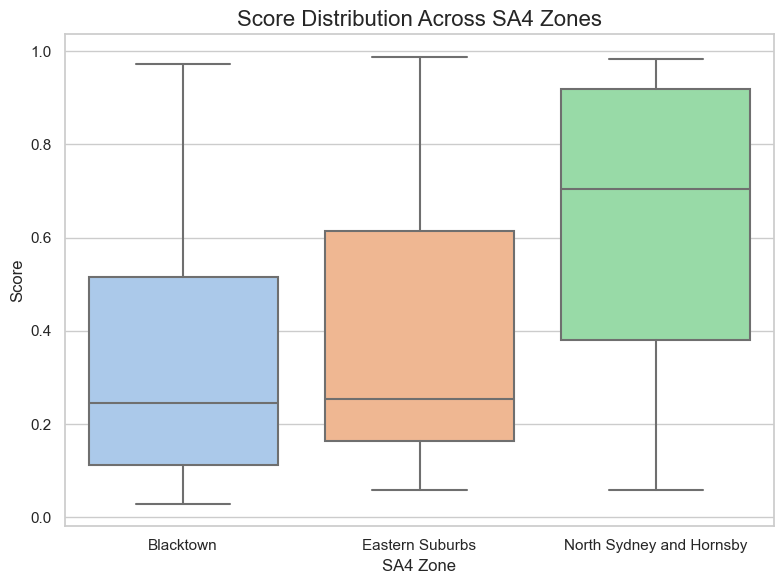

In [50]:
#  scores compare across SA4 zones
import seaborn as sns
sql = """
SELECT sa4_name, score
FROM sa2_scores
JOIN sa2_selected
ON sa2_scores.sa2_id = sa2_selected.sa2_id 
"""
with db.begin() as conn:
    sa4_scores = query(conn, sql)
sa4_scores["sa4_name"] = sa4_scores["sa4_name"].str.replace("Sydney - ", "")
order = sa4_scores.groupby("sa4_name")["score"].median().sort_values().index
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(8, 6))
sns.boxplot(x="sa4_name", y="score", data=sa4_scores, order=order)
# plt.xticks(rotation=45, ha='right')
plt.title("Score Distribution Across SA4 Zones", fontsize=16)
plt.xlabel("SA4 Zone", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.tight_layout()
plt.show()

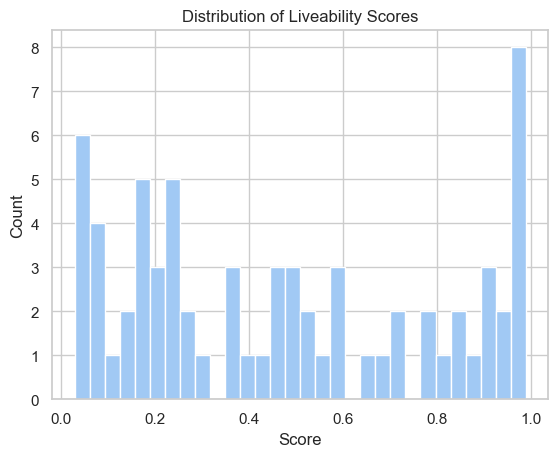

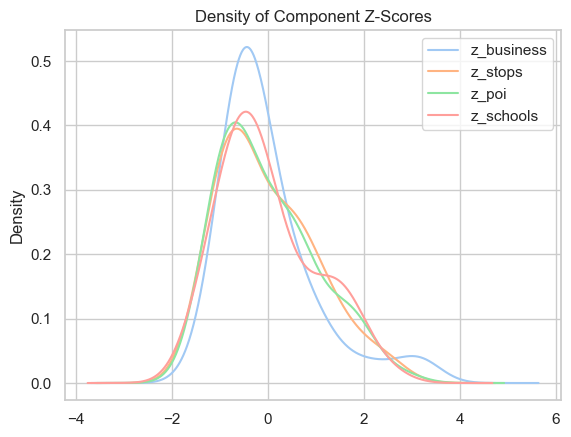

In [51]:
# Histogram of final scores
fig, ax = plt.subplots()
scores["score"].hist(bins=30, ax=ax)
ax.set_title("Distribution of Liveability Scores")
ax.set_xlabel("Score")
ax.set_ylabel("Count")
plt.show()

# Density plots of z-scores
fig, ax = plt.subplots()
for comp in ["z_business","z_stops","z_poi","z_schools"]:
    scores[comp].plot(kind="kde", ax=ax, label=comp)
ax.set_title("Density of Component Z-Scores")
ax.legend()
plt.show()

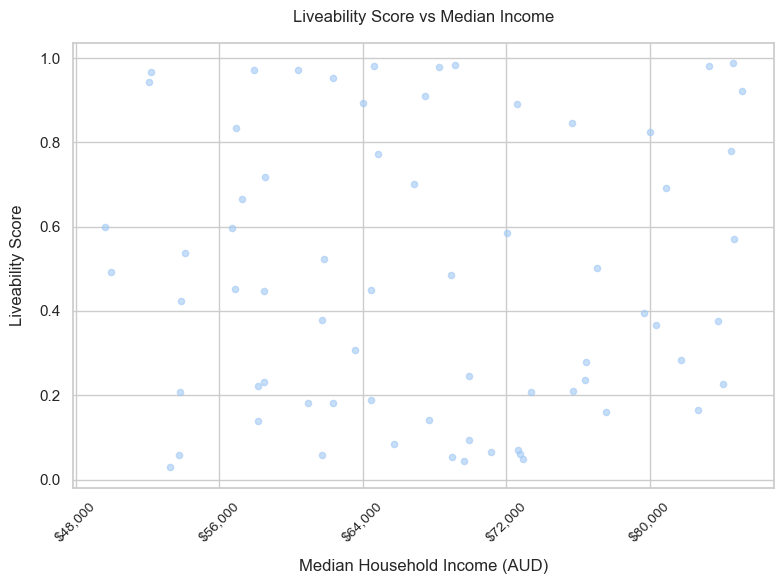

In [52]:

import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(8,6))

sql = """
SELECT * 
FROM sa2_scores
JOIN income
ON sa2_scores.sa2_id = income.sa2_id 
"""
with db.begin() as conn:
    scores_income = query(conn, sql)

scores_income.plot.scatter(
    x="median_income",
    y="score",
    ax=ax,
    alpha=0.6
)

# 1) Limit to ~6 ticks
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
# 2) Prefix with “$” and add thousand‐separators
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
# 3) Rotate for readability
ax.tick_params(axis='x', rotation=45, labelsize=10)

# 4) Axis labels with units
ax.set_xlabel("Median Household Income (AUD)", labelpad=10)
ax.set_ylabel("Liveability Score", labelpad=10)

ax.set_title("Liveability Score vs Median Income", pad=15)
plt.tight_layout()
plt.show()


In [53]:
sql = """
SELECT CORR(sa2_scores.score, CAST(income.median_income AS numeric)) AS corr_income
FROM sa2_scores 
JOIN income
ON sa2_scores.sa2_id = income.sa2_id 
"""
with db.begin() as conn:
    corr_income = query(conn, sql)['corr_income'][0]
print(f"Pearson correlation between liveability score and median income = {corr_income:.3f}")

Pearson correlation between liveability score and median income = -0.002
